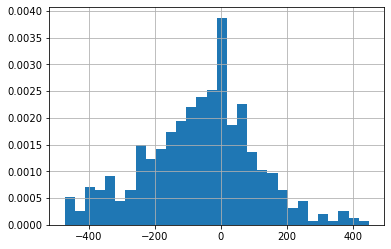

In [6]:
import os
import pandas as pd
import numpy as np
from mol_lib import xtb_isomers, FromXtbToSpinM, FromFormulaToAtomsList, FromFormulaToElectronCore, FromFormulaToElectron, FromNetworkDataFrameToNetworkClassList, reaction
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats

with open("/Users/tinaccil/Documents/GitHub/woon_query/data_analysis/dataframe/molecules_info.csv","r") as data:
	df_mol = pd.read_csv(data, delimiter = '\t')
with open("/Users/tinaccil/Documents/GitHub/woon_query/data_analysis/dataframe/network.csv","r") as data:
	df_net = pd.read_csv(data, delimiter = '\t')

df_net['diff'] = df_net['Reaction_Energy(kJ/mol)_xtb'] - df_net['Reaction_Energy(kJ/mol)_Woon']
df_net['diff'].hist(bins=30,density=True)


#fig = df_net['diff'].plot(kind='hist',bins=30,normed=True,title='$\Delta \mathrm{E}_r(xTB-GFN2) - \Delta \mathrm{E}_r(CCSD(T)) \quad [kJ/mol]$').get_figure()
#fig.savefig('hist.svg')


#max_val = df_net['diff'].abs().max()
#df_net['diff_norm'] = df_net['diff'].apply(lambda x: x / max_val * 2)


tmp_h = []
tmp_c = []
tmp_n = []
tmp_o = []
for index, rows in df_mol.iterrows():
	tmp_f = rows.formula
	tmp_l = FromFormulaToAtomsList(tmp_f)
	tmp_h.append(tmp_l[0])
	tmp_c.append(tmp_l[1])
	tmp_n.append(tmp_l[2])
	tmp_o.append(tmp_l[3])
df_mol['H'] = tmp_h
df_mol['C'] = tmp_c
df_mol['N'] = tmp_n
df_mol['O'] = tmp_o

df_net.sort_values(by=['diff'],inplace=True)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(df_net)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(df_mol)

In [ ]:
df_net = df_net[df_net['Reaction_Energy(kJ/mol)_Woon'] != 0]

a_list = ['H1_0','C1_0','N1_0','O1_0','H2_0','C2_0','N2_0','O2_0','H1C1_0','H1N1_0','H1O1_0','C1N1_0','C1O1_0','N1O1_0']

dif = df_net['diff'].tolist()
net = FromNetworkDataFrameToNetworkClassList(df_net)

N = df_net['diff'].shape[0]
M = df_mol['formula'].shape[0]#len(a_list)

D = np.zeros(shape=(N,1))
A = np.zeros(shape=(N,M))

for i,items in enumerate(net):
    D[i] =  - dif[i]
    for j,item in enumerate(net[i].reactants):
        if net[i].reactants[j] in a_list:
            tmp_i = df_mol.index[df_mol['ID'] == net[i].reactants[j]]
            A[i][int(tmp_i[0])] += + 1
    for j,item in enumerate(net[i].products):
        if net[i].products[j] in a_list:        
            tmp_i = df_mol.index[df_mol['ID'] == net[i].products[j]]
            A[i][int(tmp_i[0])] += - 1

from scipy.sparse.linalg import lsqr

res = lsqr(A=A,b=D)

#print(res)

x = list(res[0])

tmp_e = []
for i,items in enumerate(net):
    tmp_r = 0
    for j,item in enumerate(net[i].reactants):
        tmp_i = df_mol.index[df_mol['ID'] == net[i].reactants[j]]
        tmp_r +=  x[tmp_i[0]]# + float(df_mol.iloc[tmp_i,10])
    tmp_p = 0
    for j,item in enumerate(net[i].products):
        tmp_i = df_mol.index[df_mol['ID'] == net[i].products[j]]
        tmp_p +=  x[tmp_i[0]]# + float(df_mol.iloc[tmp_i,10])
    tmp_e.append((tmp_p - tmp_r))

df_net['gamma'] = tmp_e
#df_net['diff_opt'] = df_net['gamma'] - df_net['diff']
df_net['xtb_opt'] = df_net['Reaction_Energy(kJ/mol)_xtb'] - df_net['gamma']
df_net['diff_opt'] = df_net['xtb_opt'] - df_net['Reaction_Energy(kJ/mol)_Woon']

df_mol['opt'] = x
df_mol['xtb_opt'] = df_mol['opt'] + df_mol['energy(kJ/mol)_xtb']

#ax = df_mol.plot(x='name', y='energy(kJ/mol)_xtb', kind='scatter', color='Blue', label='Woon')
#df_mol.plot(x='name', y='xtb_opt', color='Red', kind='scatter',ax=ax, label='xTB', figsize=(20,10))
#plt.xticks(rotation=90)

df_net['diff_opt'].hist(bins=30)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_net)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(df_mol)

In [ ]:
class rec:
	def __init__(self,rct):
		self.reactants    = rct[0]
		self.products     = rct[1]

r1 = [['C1_0','H1_0'],['H1C1_0']]
r2 = [['C1_0','H1_0','H1_0'],['H2C1_0']]
r3 = [['C1_0','H1_0','H1_0','H1_0'],['H3C1_0']]
r4 = [['C1_0','H1_0','H1_0','H1_0','H1_0'],['H4C1_0']]
r5 = [['H1C1_0','H1_0'],['H2C1_0']]
r6 = [['H1C1_0','H1_0','H1_0'],['H3C1_0']]
r7 = [['H1C1_0','H1_0','H1_0','H1_0'],['H4C1_0']]
r8 = [['H2C1_0','H1_0'],['H3C1_0']]
r9 = [['H2C1_0','H1_0','H1_0'],['H4C1_0']]
r10 = [['H3C1_0','H1_0'],['H4C1_0']]
'''
r11 = [['N1_0','H1_0'],['H1N1_0']]
r12 = [['N1_0','H1_0','H1_0'],['H2N1_0']]
r13 = [['N1_0','H1_0','H1_0','H1_0'],['H3N1_0']]
r14 = [['H1N1_0','H1_0'],['H2N1_0']]
r15 = [['H1N1_0','H1_0','H1_0'],['H3N1_0']]
r16 = [['H2N1_0','H1_0'],['H3N1_0']]
'''
r = [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]#,r11,r12,r13,r14,r15,r16]
network = []
for i,item in enumerate(r):
    network.append(rec(item))

mol_list = ['C1_0','H1_0','H1C1_0','H2C1_0','H3C1_0','H4C1_0']#,'N1_0','H1N1_0','H2N1_0','H3N1_0']
df_test_mol = pd.DataFrame()
df_test_mol['mol'] = mol_list

tmp_w = []
tmp_x = []
for i,item in enumerate(mol_list):
    tmp_i = df_mol.index[df_mol['ID'] == mol_list[i]]
    tmp_w.append(float(df_mol.iloc[tmp_i,10]))
    tmp_x.append(float(df_mol.iloc[tmp_i,7]))

df_test_mol['xtb'] = tmp_x
df_test_mol['woon'] = tmp_w



df_test_net = pd.DataFrame()
name_list = []
tmp_e_x = []
tmp_e_w = []
tmp_e_c = []
for i,items in enumerate(network):
    tmp_n = ''
    tmp_r_x = 0
    tmp_r_w = 0
    tmp_r_c = 0
    for j,item in enumerate(network[i].reactants):
        tmp_n = tmp_n + item + '+'
        tmp_i = df_test_mol.index[df_test_mol['mol'] == network[i].reactants[j]]
        tmp_r_x +=  float(df_test_mol.iloc[tmp_i,1])
        tmp_r_w +=  float(df_test_mol.iloc[tmp_i,2])
    tmp_n = tmp_n[:-1]
    tmp_n = tmp_n + '->'
    tmp_p_x = 0
    tmp_p_w = 0
    tmp_p_c = 0
    for j,item in enumerate(network[i].products):
        tmp_n = tmp_n + item + '+'
        tmp_i = df_test_mol.index[df_test_mol['mol'] == network[i].products[j]]
        tmp_p_x +=  float(df_test_mol.iloc[tmp_i,1])
        tmp_p_w +=  float(df_test_mol.iloc[tmp_i,2])
    tmp_n = tmp_n[:-1]
    name_list.append(tmp_n)
    tmp_e_x.append(tmp_p_x - tmp_r_x)
    tmp_e_w.append(tmp_p_w - tmp_r_w)

df_test_net['reaction'] = name_list
df_test_net['woon'] = tmp_e_x
df_test_net['xtb'] = tmp_e_w
df_test_net['diff'] = df_test_net['xtb'] - df_test_net['woon']

dif = df_test_net['diff'].tolist()

N = df_test_net['diff'].shape[0]
M = df_test_mol['mol'].shape[0]

D = np.zeros(shape=(N,1))
A = np.zeros(shape=(N,M))

for i,items in enumerate(network):
    D[i] =  dif[i]
    for j,item in enumerate(network[i].reactants):
        if 'H1_0' == network[i].reactants[j] or 'C1_0' == network[i].reactants[j]:
            tmp_i = df_test_mol.index[df_test_mol['mol'] == network[i].reactants[j]]
            A[i][int(tmp_i[0])] += - 1
    for j,item in enumerate(network[i].products):
        if 'H1_0' == network[i].products[j] or 'C1_0' == network[i].products[j]:
            tmp_i = df_test_mol.index[df_test_mol['mol'] == network[i].products[j]]
            A[i][int(tmp_i[0])] += + 1

from scipy.sparse.linalg import lsqr
res = lsqr(A=A,b=D)
x = list(res[0])

tmp_e = []
for i,items in enumerate(network):
    tmp_r = 0
    for j,item in enumerate(network[i].reactants):
        tmp_i = df_test_mol.index[df_test_mol['mol'] == network[i].reactants[j]]
        tmp_r +=  x[tmp_i[0]] #+ float(df_test_mol.iloc[tmp_i,1])
    tmp_p = 0
    for j,item in enumerate(network[i].products):
        tmp_i = df_test_mol.index[df_test_mol['mol'] == network[i].products[j]]
        tmp_p +=  x[tmp_i[0]] #+ float(df_test_mol.iloc[tmp_i,1])
    tmp_e.append((tmp_p - tmp_r))

df_test_mol['corr'] = x
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_test_mol)

df_test_net['n_diff'] = tmp_e
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_test_net)


In [ ]:
class rec:
	def __init__(self,rct):
		self.reactants    = rct[0]
		self.products     = rct[1]

r1 = [['C1_0','H1_0'],['H1C1_0']]
r2 = [['C1_0','H1_0','H1_0'],['H2C1_0']]
r3 = [['C1_0','H1_0','H1_0','H1_0'],['H3C1_0']]
r4 = [['C1_0','H1_0','H1_0','H1_0','H1_0'],['H4C1_0']]
r5 = [['H1C1_0','H1_0'],['H2C1_0']]
r6 = [['H1C1_0','H1_0','H1_0'],['H3C1_0']]
r7 = [['H1C1_0','H1_0','H1_0','H1_0'],['H4C1_0']]
r8 = [['H2C1_0','H1_0'],['H3C1_0']]
r9 = [['H2C1_0','H1_0','H1_0'],['H4C1_0']]
r10 = [['H3C1_0','H1_0'],['H4C1_0']]

'''
r1 = [['N1_0','H1_0'],['H1N1_0']]
r2 = [['N1_0','H1_0','H1_0'],['H2N1_0']]
r3 = [['N1_0','H1_0','H1_0','H1_0'],['H3N1_0']]
r4 = [['H1N1_0','H1_0'],['H2N1_0']]
r5 = [['H1N1_0','H1_0','H1_0'],['H3N1_0']]
r6 = [['H2N1_0','H1_0'],['H3N1_0']]
'''

r = [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
network = []
for i,item in enumerate(r):
    network.append(rec(item))

m_hc = 0.883273 
q_hc = -65.39287

list_n = []

'''
h = -29.80464418061524 
c = -302.73772821988496 
n = -254.14788855376537
'''

tmp_e_x = []
tmp_e_w = []
tmp_e_c = []
for i,items in enumerate(network):
    tmp_r_x = 0
    tmp_r_w = 0
    tmp_r_c = 0
    for j,item in enumerate(network[i].reactants):
        tmp_i = df_mol.index[df_mol['ID'] == network[i].reactants[j]]
        tmp_r_x +=  float(df_mol.iloc[tmp_i,10])
        tmp_r_w +=  float(df_mol.iloc[tmp_i,7])
        if network[i].reactants[j] == 'H1_0':
            tmp_r_c +=  (float(df_mol.iloc[tmp_i,10]) ) #* int(df_mol.iloc[tmp_i,13])
        elif network[i].reactants[j] == 'H1C1_0':
            tmp_r_c += (float(df_mol.iloc[tmp_i,10]) + q_ch)
        elif network[i].reactants[j] == 'H2C1_0':
            tmp_r_c += (float(df_mol.iloc[tmp_i,10]) )
        else:
            tmp_r_c += float(df_mol.iloc[tmp_i,10])
    tmp_p_x = 0
    tmp_p_w = 0
    tmp_p_c = 0
    for j,item in enumerate(network[i].products):
        tmp_i = df_mol.index[df_mol['ID'] == network[i].products[j]]
        tmp_p_x +=  float(df_mol.iloc[tmp_i,10])
        tmp_p_w +=  float(df_mol.iloc[tmp_i,7])
        if network[i].products[j] == 'H1_0':
            tmp_p_c +=  (float(df_mol.iloc[tmp_i,10]) )
        elif network[i].products[j] == 'H1C1_0':
            tmp_p_c += (float(df_mol.iloc[tmp_i,10]) + + q_ch)
        elif network[i].products[j] == 'H2C1_0':
            tmp_p_c += (float(df_mol.iloc[tmp_i,10]) )
        else:
            tmp_p_c += float(df_mol.iloc[tmp_i,10]) 
    tmp_e_x.append(tmp_p_x - tmp_r_x)
    tmp_e_w.append(tmp_p_w - tmp_r_w)
    tmp_e_c.append(tmp_p_c - tmp_r_c)

    print(network[i].reactants, network[i].products, tmp_e_w[i],tmp_e_x[i],tmp_e_c[i])

In [ ]:
tmp_l = ['H1C1_0','H2C1_0','H3C1_0','H4C1_0']
#tmp_l = ['H1N1_0','H2N1_0','H3N1_0']
#tmp_l = ['H1O1_0','H2O1_0']
#tmp_l = ['H1_0','H2_0']
#tmp_l = ['H1C1N1_0','H2C1N1_1']
#tmp_l = ['H1O2_0','H2O2_0']
#tmp_l = ['H1C1_0','H1N1_0','H1O1_0']
#tmp_l = ['C1O1_0','C1O2_1']
#tmp_l = ['C1O1_0','C2O1_1']
#tmp_l = ['H1C1_0','H1C2_0','H1C3_1','H1C4_5']

h_x = -1033.0896786510627 
h_w = -1312.2520212974064
c_x = -4713.065776810578
c_w = -99193.45611463605
n_x = -6851.121942977629
n_w = -143128.45771630394
o_x = -9896.62162443879
o_w = -196844.26717987825
o2_x = -20759.19186732056 
o2_w = -394193.7701602935
cn_x = -12854.387667171362
cn_w = -243047.38196786572

df_mol_c = df_mol[df_mol['ID'].isin(tmp_l)]


X = df_mol_c['energy(kJ/mol)_woon'].values# - n_w# - df_mol_c['H'].values * h_w
Y = df_mol_c['energy(kJ/mol)_xtb'].values# - n_x# - df_mol_c['H'].values * h_x

slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
y = intercept + slope * X

print("slope: %f intercept: %f r: %f stderror: %f" % (slope, intercept,r_value,std_err))
lab = 'm=' + str(slope)[:7] + ' // q=' + str(intercept)[:8]

plt.figure(figsize=(10,5))
plt.plot(X,y, color='Red', label=lab)
plt.scatter(X,Y, color='Blue')
plt.xlabel('Energy(kJ/mol)_cc')
plt.ylabel('Energy(kJ/mol)_xtb')
plt.legend()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_mol_c)


In [ ]:
plt.scatter(X,Y-y, color='Blue')

In [ ]:
x = ['NH','NH2','NH3']
xtb = [-8413.109096,-10000.3405,-11621.11139]
#xtb_c =[-8359.27085,-9892.664007,-11459.59665]
xtb_c =[-8649.125391,-10472.37309,-12093.14398]
plt.scatter(x,xtb, color='Blue',label='xTB')
plt.scatter(x,xtb_c, color='Red',label='xTB corrected m=1')
plt.legend()

In [ ]:
x = ['NH3-NH2','NH3-NH','NH2-NH']
w = [-1788,-3507,-1719]
xtb = [-1621,-3208,-1587]
#xtb_c =[-1567,-3100,-1533]
xtb_c =[-1567,-3100,-1533]
plt.scatter(x,w, color='Green',label='woon')
plt.scatter(x,xtb, color='Blue',label='xTB')
plt.scatter(x,xtb_c, color='Red',label='xTB corrected m=1')
plt.legend()

In [ ]:
from scipy.optimize import curve_fit

def func(x, a):
    return x + a

params, params_covariance = curve_fit(func,X,Y)
print(params[0])
y = func(X, params[0])
lab = 'm=1' + ' // q=' + str(params[0])[:8]
plt.scatter(X,Y, color='Blue')
plt.plot(X, y,color='Red',label=lab)
plt.xlabel('Energy(kJ/mol)_cc')
plt.ylabel('Energy(kJ/mol)_xtb')
plt.legend()

In [ ]:
plt.scatter(X,Y-y, color='Blue')

In [ ]:
x = ['CH','CH2','CH3','CH4']
xtb = [-6251.102486,-7791.127762,-9354.584071,-10962.04326]
#xtb_c = [-6185.709486,-7660.341762,-9158.405071,-10700.47126]
xtb_c =[-6689.377986,-8667.678762,-10669.41057,-12715.14526]

plt.scatter(x,xtb, color='Blue',label='xTB')
plt.scatter(x,xtb_c, color='Red',label='xTB corrected m=1')
plt.legend()

In [ ]:
x = ['CH4-CH3','CH4-CH2','CH4-CH','CH3-CH2','CH3-CH','CH2-CH']
w = [-1779,-3574,-5325,-1795,-3547,-1752]
xtb = [-1607,-3171,-4711,-1563,-3103,-1540]
#xtb_c = [-1542,-3040,-4515,-1498,-2973,-1475]
xtb_c =[-2046,-4047,-6026,-2002,-3980,-1978]
plt.scatter(x,w, color='Green',label='woon')
plt.scatter(x,xtb, color='Blue',label='xTB')
plt.scatter(x,xtb_c, color='Red',label='xTB corrected m=1')
plt.legend()

In [ ]:
from scipy.optimize import curve_fit

def func(x, a):
    return x + a

params, params_covariance = curve_fit(func,X,Y)
print(params[0])
y = func(X, params[0])
lab = 'm=1' + ' // q=' + str(params[0])[:8]
plt.scatter(X,Y, color='Blue')
plt.plot(X, y,color='Red',label=lab)
plt.xlabel('Energy(kJ/mol)_cc')
plt.ylabel('Energy(kJ/mol)_xtb')
plt.legend()

In [ ]:
plt.scatter(X,Y-y, color='Blue')

In [ ]:
df_net_a = df_net.copy()
df_net_b = df_net.copy()
df_mol_r = df_mol.copy()
df_net_a = df_net_a[df_net_a['Reaction_Energy(kJ/mol)_Woon'] != 0]
df_net_b = df_net_b[df_net_b['Reaction_Energy(kJ/mol)_Woon'] != 0]

a_list = ['H1_0','C1_0','N1_0','O1_0','H2_0','C2_0','N2_0','O2_0','H1C1_0','H1N1_0','H1O1_0','C1N1_0','C1O1_0','N1O1_0']
#a_list = ['H1_0','C1_0','N1_0','O1_0']
#for i in range(len(a_list)):
i=3
tmp_a = a_list[i]
tmp_l = a_list.copy()
tmp_l.pop(i)

n = tmp_a[:1]
df_mol_r = df_mol_r[df_mol_r[n] == 1]
tmp_n1 =  df_mol_r['ID'].tolist()
df_net_b = df_net_b[(~df_net_b['R1'].isin(tmp_n1)) & (~df_net_b['R2'].isin(tmp_n1)) & (~df_net_b['P1'].isin(tmp_n1)) & (~df_net_b['P2'].isin(tmp_n1)) & (~df_net_b['P3'].isin(tmp_n1))]
df_net_b = df_net_b[(~df_net_b['R1'].isin(a_list)) & (~df_net_b['R2'].isin(a_list)) & (~df_net_b['P1'].isin(a_list)) & (~df_net_b['P2'].isin(a_list)) & (~df_net_b['P3'].isin(a_list))]

df_net_a = df_net_a[(df_net_a['R1'] == tmp_a) | (df_net_a['R2'] == tmp_a) | (df_net_a['P1'] == tmp_a) | (df_net_a['P2'] == tmp_a) | (df_net_a['P3'] == tmp_a)]
df_net_a = df_net_a[(~df_net_a['R1'].isin(tmp_l)) & (~df_net_a['R2'].isin(tmp_l)) & (~df_net_a['P1'].isin(tmp_l)) & (~df_net_a['P2'].isin(tmp_l)) & (~df_net_a['P3'].isin(tmp_l))]
df_net.reset_index(drop=True, inplace=True)

#df_net_a.plot(x='Reaction_Energy(kJ/mol)_Woon', y='Reaction_Energy(kJ/mol)_xtb', color='Red', kind='scatter',figsize=(20,10))

X = df_net_a['Reaction_Energy(kJ/mol)_Woon'].values
Y = df_net_a['Reaction_Energy(kJ/mol)_xtb'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
y = intercept + slope * X

print("slope: %f    intercept: %f r: %f" % (slope, intercept,r_value))
lab = 'm=' + str(slope)[:7] + ' // q=' + str(intercept)[:8] + ' // r=' + str(r_value)[:5]

plt.figure(figsize=(10,5))
plt.plot(X,y, color='Red',label=lab)
plt.scatter(X,Y, color='Blue',label=tmp_a[:-2])
plt.scatter(df_net_b['Reaction_Energy(kJ/mol)_Woon'].values,df_net_b['Reaction_Energy(kJ/mol)_xtb'].values, color='Green',label='1')
plt.xlabel('Reaction_Energy(kJ/mol)_Woon')
plt.ylabel('Reaction_Energy(kJ/mol)_xtb')
plt.legend()
plt.show()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_net_a)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_net_b)

In [ ]:
int_list = [-65.392870]
#int_list = [-18.864255,-40.321660,-59.966035,-361.373209]
#int_list = [-30.502692,-225.275349,-326.042778,-313.442724]
net = FromNetworkDataFrameToNetworkClassList(df_net)

h1 = df_mol.index[df_mol['ID'] == 'H1_0']
#c1 = df_mol.index[df_mol['ID'] == 'C1_0']
#n1 = df_mol.index[df_mol['ID'] == 'N1_0']
#o1 = df_mol.index[df_mol['ID'] == 'O1_0']
df_mol.iloc[h1,10] = df_mol.iloc[h1,10] + int_list[0]
#df_mol.iloc[c1,10] = df_mol.iloc[c1,10] + int_list[1]
#df_mol.iloc[n1,10] = df_mol.iloc[n1,10] + int_list[2]
#df_mol.iloc[o1,10] = df_mol.iloc[o1,10] + int_list[3]

tmp_e = []
for i,items in enumerate(net):
    tmp_r = 0
    for j,item in enumerate(net[i].reactants):
        tmp_i = df_mol.index[df_mol['ID'] == net[i].reactants[j]]
        tmp_r +=  float(df_mol.iloc[tmp_i,10])
    tmp_p = 0
    for j,item in enumerate(net[i].products):
        tmp_i = df_mol.index[df_mol['ID'] == net[i].products[j]]
        tmp_p +=  float(df_mol.iloc[tmp_i,10])
    tmp_e.append((tmp_p - tmp_r))

df_net['new_e_xtb'] = tmp_e
df_net['diff_n'] = df_net['new_e_xtb'] - df_net['Reaction_Energy(kJ/mol)_Woon']
#df_net['diff'].hist(bins=30)
df_net['diff_n'].hist(bins=30)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_net)


In [ ]:

#ax = df_mol_n.plot(x='formula', y='energy(kJ/mol)_woon', kind='scatter', color='Blue', label='Woon')
#df_mol_n.plot(x='formula', y='energy(kJ/mol)_xtb', color='Red', kind='scatter',ax=ax, label='xTB', figsize=(20,10))
#plt.xticks(rotation=90)

h1 = df_mol.index[df_mol['ID'] == 'H1_0']
h2 = df_mol.index[df_mol['ID'] == 'H2_0']
c1 = df_mol.index[df_mol['ID'] == 'C1_0']
c2 = df_mol.index[df_mol['ID'] == 'C2_0']
n1 = df_mol.index[df_mol['ID'] == 'N1_0']
n2 = df_mol.index[df_mol['ID'] == 'N2_0']
o1 = df_mol.index[df_mol['ID'] == 'O1_0']
o2 = df_mol.index[df_mol['ID'] == 'O2_0']


H_w = float(df_mol.iloc[h2,7]) - float(df_mol.iloc[h1,7]) * 2
H_x = float(df_mol.iloc[h2,10]) - float(df_mol.iloc[h1,10]) * 2
C_w = float(df_mol.iloc[c2,7]) - float(df_mol.iloc[c1,7]) * 2
C_x = float(df_mol.iloc[c2,10]) - float(df_mol.iloc[c1,10]) * 2
N_w = float(df_mol.iloc[n2,7]) - float(df_mol.iloc[n1,7]) * 2
N_x = float(df_mol.iloc[n2,10]) - float(df_mol.iloc[n1,10]) * 2
O_w = float(df_mol.iloc[o2,7]) - float(df_mol.iloc[o1,7]) * 2
O_x = float(df_mol.iloc[o2,10]) - float(df_mol.iloc[o1,10]) * 2

e_h = -(H_w - H_x) * 0.5
e_c = -(C_w - C_x) * 0.5
e_n = -(N_w - N_x) * 0.5
e_o = -(O_w - O_x) * 0.5

print(e_h,e_c,e_n,e_o)

df_mol.iloc[h1,10] = df_mol.iloc[h1,10] + e_h
df_mol.iloc[c1,10] = df_mol.iloc[c1,10] + e_c
df_mol.iloc[n1,10] = df_mol.iloc[n1,10] + e_n
df_mol.iloc[o1,10] = df_mol.iloc[o1,10] + e_o

H_xp = float(df_mol.iloc[h2,10]) - float(df_mol.iloc[h1,10]) * 2
C_xp = float(df_mol.iloc[c2,10]) - float(df_mol.iloc[c1,10]) * 2
N_xp = float(df_mol.iloc[n2,10]) - float(df_mol.iloc[n1,10]) * 2
O_xp = float(df_mol.iloc[o2,10]) - float(df_mol.iloc[o1,10]) * 2

print(H_x,H_xp)
print(C_x,C_xp)
print(N_x,N_xp)
print(O_x,O_xp)


net = FromNetworkDataFrameToNetworkClassList(df_net)
tmp_e = []
for i,items in enumerate(net):
    tmp_r = 0
    for j,item in enumerate(net[i].reactants):
        tmp_i = df_mol.index[df_mol['ID'] == net[i].reactants[j]]
        tmp_r +=  float(df_mol.iloc[tmp_i,10])
    tmp_p = 0
    for j,item in enumerate(net[i].products):
        tmp_i = df_mol.index[df_mol['ID'] == net[i].products[j]]
        tmp_p +=  float(df_mol.iloc[tmp_i,10])
    tmp_e.append((tmp_p - tmp_r))
df_net['xtb_n'] = tmp_e
df_net['diff_n'] = df_net['xtb_n'] - df_net['Reaction_Energy(kJ/mol)_Woon']

df_net['diff_n'].hist(bins=30)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_net)

In [ ]:
df_net = df_net[df_net['Reaction_Energy(kJ/mol)_Woon'] != 0]
net = FromNetworkDataFrameToNetworkClassList(df_net)
net_ix = FromNetworkDataFrameToNetworkClassList(df_net)

for i,items in enumerate(net):
    for j,item in enumerate(net[i].reactants):
        tmp_i = df_mol.index[df_mol['ID'] == net[i].reactants[j]]
        net[i].reactants[j] = float(df_mol.iloc[tmp_i,10])
        net_ix[i].reactants[j] = int(tmp_i[0])
    for j,item in enumerate(net[i].products):
        tmp_i = df_mol.index[df_mol['ID'] == net[i].products[j]]
        net[i].products[j] = float(df_mol.iloc[tmp_i,10])
        net_ix[i].products[j] = int(tmp_i[0])
 
e_w = df_net['Reaction_Energy(kJ/mol)_Woon'].tolist()
dim_df = df_mol['formula'].shape[0]
x0 = np.ones(shape=(dim_df,1))

def opt_energy(x,net,net_ix,e_w):
    tmp_e = 0
    for i,items in enumerate(net):
        tmp_r = 0
        for j,item in enumerate(net[i].reactants):
            tmp_r +=  x[net_ix[i].reactants[j]] + net[i].reactants[j]
        tmp_p = 0
        for j,item in enumerate(net[i].products):
            tmp_p +=  x[net_ix[i].products[j]] + net[i].products[j]
        tmp_e = tmp_e + (tmp_p - tmp_r) - e_w[i]
    tmp_e = tmp_e.item(0) ** 2
    return tmp_e

from scipy.optimize import minimize

res = minimize(fun=opt_energy, x0=x0, args=(net,net_ix,e_w), method='Nelder-Mead')

In [ ]:
df_mol_t = df_mol.copy()
df_mol_t = df_mol_t.drop(columns={'Na','Mass','state_woon','multiplicity_woon','energy(kJ/mol)_woon','spin_input_xtb','multiplicity_xtb','energy(kJ/mol)_xtb','pwd_xyz_woon','pwd_xyz_xtb'})

for index, rows in df_net.iterrows():
    tmp_n = rows.Reaction_Image
    df_mol_t[tmp_n] = 0
    df_mol_t.loc[df_mol_t['ID'] == rows.R1, tmp_n] = df_mol_t[tmp_n].loc[df_mol_t['ID'] == rows.R1] + 1
    df_mol_t.loc[df_mol_t['ID'] == rows.R2, tmp_n] = df_mol_t[tmp_n].loc[df_mol_t['ID'] == rows.R2] + 1
    df_mol_t.loc[df_mol_t['ID'] == rows.P1, tmp_n] = df_mol_t[tmp_n].loc[df_mol_t['ID'] == rows.P1] - 1
    df_mol_t.loc[df_mol_t['ID'] == rows.P2, tmp_n] = df_mol_t[tmp_n].loc[df_mol_t['ID'] == rows.P2] - 1
    df_mol_t.loc[df_mol_t['ID'] == rows.P3, tmp_n] = df_mol_t[tmp_n].loc[df_mol_t['ID'] == rows.P3] - 1

df_mol_tp = df_mol_t.copy()
df_mol_tp = df_mol_tp.drop(columns={'formula','ID'})
df_mol_tp = df_mol_tp.T
df_mol_tp.columns = df_mol_tp.iloc[0]
df_mol_tp = df_mol_tp.drop(df_mol_tp.index[0])
df_mol_tp['name'] = df_mol_tp.index

df_net_n = pd.merge(left=df_net, right=df_mol_tp, how='left', left_on='Reaction_Image', right_on='name')
df_net_n = df_net_n.drop(columns='name')

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(df_mol_t)

In [ ]:
df_net_m = df_net_n.copy()
df_net_m = df_net_m.drop(columns={'R1','R2','R3','P1','P2','P3','P4','P5','ID_kida','Reaction_Energy(kJ/mol)_Woon','Reaction_Energy(kJ/mol)_xtb','Reaction_Image','diff'})

arr = df_net_m.to_numpy()

bandwidth = estimate_bandwidth(arr,quantile=0.024)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(arr)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

df_net_up = df_net.copy()

df_net_up['label'] = labels

print("number of estimated clusters : %d" % n_clusters_)

def FromLabelToColor(df,label):
    categories = np.unique(df[label])
    colors = cm.rainbow(np.linspace(0, 1, len(categories)))
    colordict = dict(zip(categories, colors))  
    df["Color"] = df[label].apply(lambda x: colordict[x])
    return(df)

df_net_up = FromLabelToColor(df_net_up,'label')
df_net_up['num'] = np.arange(df_net_up.shape[0])

df_net_up.plot(x='Reaction_Energy(kJ/mol)_Woon', y='Reaction_Energy(kJ/mol)_xtb', color=df_net_up.Color, kind='scatter', figsize=(20,10))
df_net_up.plot(x='num', y='diff', color=df_net_up.Color, kind='scatter', figsize=(20,10))



#ax = df_mol.plot(x='name', y='energy(kJ/mol)_woon', kind='scatter', color='Blue', label='Woon')
#df_net_n.plot(x=, y='diff', color=df_net_n.Color, kind='scatter', figsize=(20,10))

#df_net_n.plot(x='Reaction_Energy(kJ/mol)_Woon', y='Reaction_Energy(kJ/mol)_xtb', color='Red', kind='scatter',figsize=(20,10))

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(df_net_up)

In [ ]:
def dfScatter(df,x,y,col):
    xcol= x
    ycol= y
    catcol = col
    fig, ax = plt.subplots(figsize=(20, 10))
    categories = np.unique(df[catcol])
    colors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, colors))  
    df["Color"] = df[catcol].apply(lambda x: colordict[x])
    ax.scatter(df[xcol], df[ycol], c=df.Color)
    ax.set_ylabel(y)
    ax.set_xlabel(x)
    #name = df['name'].tolist()
    #for i, txt in enumerate(name):
    #    ax.annotate(txt, (e_w[i], e_xtb[i]))
    return fig


#fig = dfScatter(df_net_n,'Reaction_Energy(kJ/mol)_Woon','Reaction_Energy(kJ/mol)_xtb','label')
#fig = dfScatter(df_net_n,'num','diff','label')

In [ ]:
df_net['diff'] = df_net['Reaction_Energy(kJ/mol)_xtb'] - df_net['Reaction_Energy(kJ/mol)_Woon']
df_net.plot(x='ID_kida', y='diff', color='Red', kind='scatter',figsize=(20,10))
#df_net['diff'].diff().hist(bins=30)
tmp_df_net = df_net[np.abs(df_net['diff']) < 200]
tmp_df_net = df_net.copy()

In [ ]:
f1 = tmp_df_net['R1'].value_counts().tolist()
n1 = tmp_df_net['R1'].value_counts().index.tolist()
f2 = tmp_df_net['R2'].value_counts().tolist()
n2 = tmp_df_net['R2'].value_counts().index.tolist()
f3 = tmp_df_net['P1'].value_counts().tolist()
n3 = tmp_df_net['P1'].value_counts().index.tolist()
f4 = tmp_df_net['P2'].value_counts().tolist()
n4 = tmp_df_net['P2'].value_counts().index.tolist()
f5 = tmp_df_net['P3'].value_counts().tolist()
n5 = tmp_df_net['P3'].value_counts().index.tolist()

df_mol_freq = df_mol.copy()
df_mol_freq = df_mol_freq.drop(columns={'Na','Mass','state_woon','multiplicity_woon','energy(kJ/mol)_woon','spin_input_xtb','multiplicity_xtb','energy(kJ/mol)_xtb','pwd_xyz_woon','pwd_xyz_xtb'})

df_mol_freq['f_R1'] = 0
df_mol_freq['f_R2'] = 0
df_mol_freq['f_P1'] = 0
df_mol_freq['f_P2'] = 0
df_mol_freq['f_P3'] = 0

for i,item in enumerate(f1):
    df_mol_freq.loc[df_mol_freq['ID'] == n1[i], 'f_R1'] = f1[i]
for i,item in enumerate(f2):
    df_mol_freq.loc[df_mol_freq['ID'] == n2[i], 'f_R2'] = f2[i]
for i,item in enumerate(f3):
    df_mol_freq.loc[df_mol_freq['ID'] == n3[i], 'f_P1'] = f3[i]
for i,item in enumerate(f4):
    df_mol_freq.loc[df_mol_freq['ID'] == n4[i], 'f_P2'] = f4[i]
for i,item in enumerate(f5):
    df_mol_freq.loc[df_mol_freq['ID'] == n5[i], 'f_P3'] = f5[i]

df_mol_freq['f_RT'] = df_mol_freq['f_R1'] + df_mol_freq['f_R2']
df_mol_freq['f_PT'] = df_mol_freq['f_P1'] + df_mol_freq['f_P2'] + df_mol_freq['f_P3']

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(df_mol_freq)

df_mol_freq.plot(x="name", y=["f_RT", "f_PT"], kind="bar",legend=True, figsize=(20,10))

In [ ]:
df_mol['core_el'] = df_mol.apply(lambda row: FromFormulaToElectronCore(row['formula']), axis=1)
df_mol['electron'] = df_mol.apply(lambda row: FromFormulaToElectron(row['formula']), axis=1)
df_mol.sort_values(by=['electron',"Mass"], inplace=True)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(df_mol)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(X, a, b, c):
    x,y  = X
    return a * x + b * y + c

name = df_mol['name'].tolist()
e_xtb = df_mol['energy(kJ/mol)_xtb'].tolist()
e_w = df_mol['energy(kJ/mol)_woon'].tolist()
e_ce = df_mol['core_el'].tolist()
e_e = df_mol['electron'].tolist()


params, params_covariance = curve_fit(func, (e_xtb,e_e), e_w)
print(params)

e_xtb_n = []
for i,item in enumerate(e_xtb):
    e_xtb_n.append(func((e_xtb[i],e_e[i]), params[0], params[1], params[2]))

plt.figure(figsize=(20, 10))
plt.scatter(name, e_w, label='woon', color='Red')
plt.scatter(name, e_xtb_n, label='f(xtb,ncore)', color='Blue')
plt.legend(loc='best')
plt.xticks(rotation=90)
#plt.ylim(1.45e-10,2.01e-10)
plt.show()   

In [ ]:
ax = df_mol.plot(x='name', y='energy(kJ/mol)_woon', kind='scatter', color='Blue', label='Woon')
df_mol.plot(x='name', y='energy(kJ/mol)_xtb', color='Red', kind='scatter',ax=ax, label='xTB', figsize=(20,10))
plt.xticks(rotation=90)

In [ ]:
#df_mol.plot(x='energy(kJ/mol)_woon', y='energy(kJ/mol)_xtb', color='Red', kind='scatter', figsize=(20,10))

fig, ax = plt.subplots(figsize=(30, 60))
ax.scatter(e_w, e_xtb)
for i, txt in enumerate(name):
    ax.annotate(txt, (e_w[i], e_xtb[i]))

In [ ]:
def norm(val,val_n):
    tmp = (val - val_n) / abs(val_n) 
    return(tmp)

max_val_x = df_mol['energy(kJ/mol)_xtb'].min()
df_mol['n_x'] = df_mol.apply(lambda row: norm(row['energy(kJ/mol)_xtb'],max_val_x), axis=1)

max_val_w = df_mol['energy(kJ/mol)_woon'].min()
df_mol['n_w'] = df_mol.apply(lambda row: norm(row['energy(kJ/mol)_woon'],max_val_w), axis=1)

ax = df_mol.plot(x='name', y='n_w', kind='scatter', color='Blue', label='Woon')
df_mol.plot(x='name', y='n_x', color='Red', kind='scatter',ax=ax, label='xTB', figsize=(20,10))
plt.xticks(rotation=90)


In [ ]:
'''
tmp_w = df_mol['multiplicity_woon'].tolist()
tmp_x = df_mol['multiplicity_xtb'].tolist()

tmp_b = []
for i,item in enumerate(tmp_w):
	if (int(tmp_w[i]) - int(tmp_x[i])) == 0:
		tmp_b.append(True)
	else:
		tmp_b.append(False)

df_mol['bool'] = tmp_b
df_mol_f = df_mol[df_mol['bool'] == False]
df_mol = df_mol.drop(["bool"], axis=1)
'''